In [1]:
print('Ну типа тут вступление должно быть')

Ну типа тут вступление должно быть


In [1]:
from tqdm import tqdm
from os import system

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys

In [2]:
sns.set(style='darkgrid', font_scale=2, palette='Set1')

In [3]:
def prepare_drawing(xlabel, ylabel, title):
    plt.figure(figsize=(12, 8))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [4]:
def set_up_xticks(start, step, count):
    ticks = np.arange(0, len(results) + step, step)
    ticks_with_start = np.append([start], ticks[1:])
    plt.xticks(ticks_with_start - start, ticks_with_start)

In [5]:
def calculate_result(graph_size, seed=0):    
    !./generate_graph.sh {graph_size} {seed}
    res = !./run.sh
    if len(res) != 1:
        print(graph_size, seed, res)
        sys.stdout.flush()
        
    return int(res[0])

In [6]:
def draw_result_graph(cycle_results, title, start=2, step=100):
    prepare_drawing('размер графа', 'Вес цикла', title)
    set_up_xticks(start, step, len(cycle_results))
    sns.lineplot(data=cycle_results, linewidth=2.5)
    
def draw_first100_graphs(cycle_results, title='Начало того же графика'):
    draw_result_graph(cycle_results, title, 2, 10)
    plt.xlim((0, 100));

In [30]:
results = []

for graph_size in tqdm(range(2, 1000)):
    results.append(calculate_result(graph_size) / graph_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [20:58<00:00,  1.26s/it]


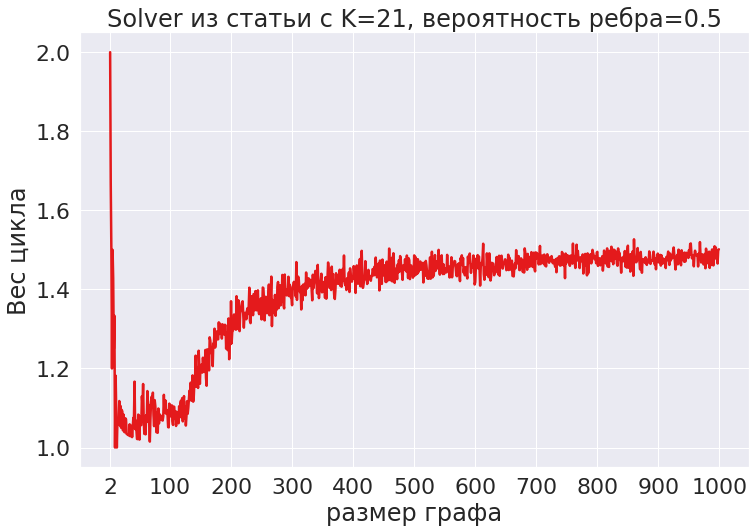

In [59]:
prepare_drawing('размер графа', 'Вес цикла', 'Solver из статьи с K=21, вероятность ребра=0.5')

step = 100
set_up_xticks(2, 100, len(results))

sns.lineplot(data=results, linewidth=2.5);

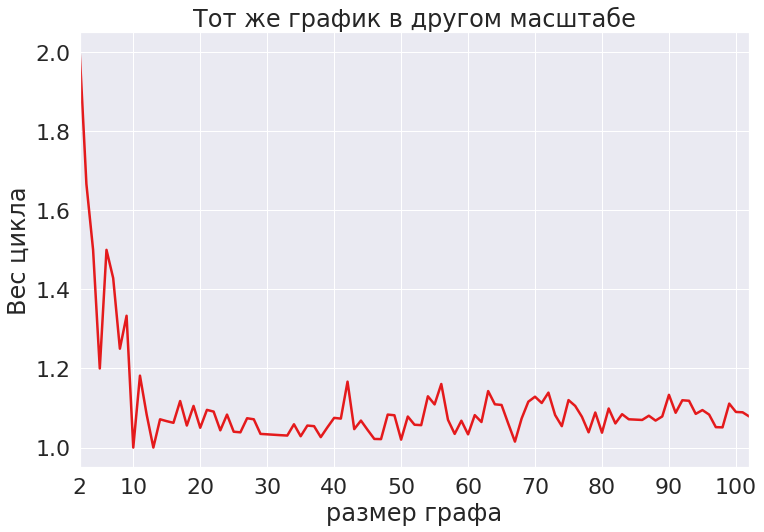

In [57]:
prepare_drawing('размер графа', 'Вес цикла', 'Тот же график в другом масштабе')

set_up_xticks(2, 10, len(results))

sns.lineplot(data=results, linewidth=2.5);
plt.xlim((0, 100));

In [17]:
results = []

for graph_size in tqdm(range(2, 100)):
    results.append(calculate_result(graph_size) / graph_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [01:56<00:00,  1.19s/it]


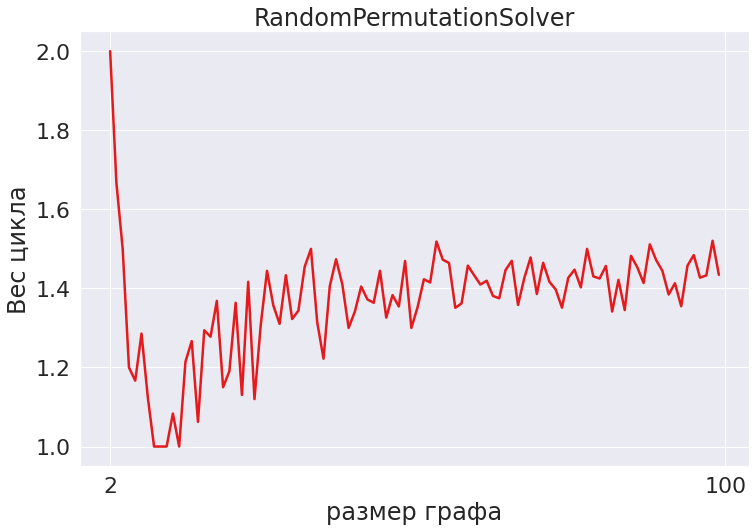

In [18]:
draw_result_graph(results, 'RandomPermutationSolver')

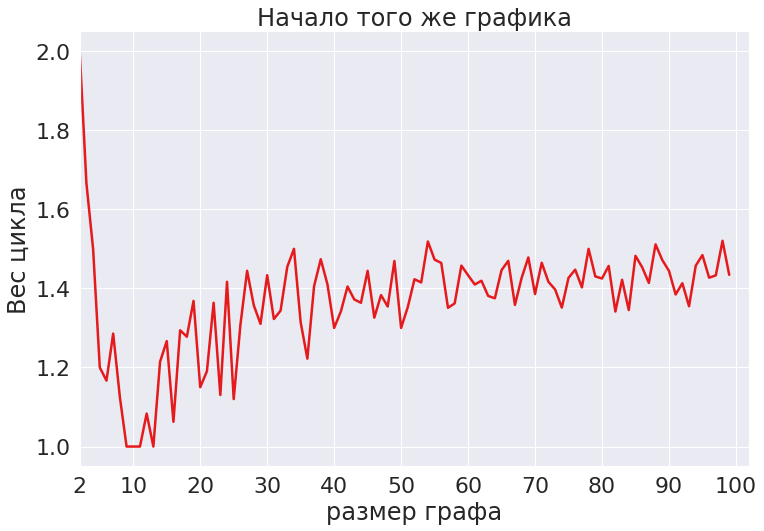

In [20]:
draw_first100_graphs(results)

In [ ]:
results = []

for graph_size in tqdm(range(2, 1000)):
    results.append(calculate_result(graph_size) / graph_size)

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 960/998 [20:03<00:50,  1.32s/it]

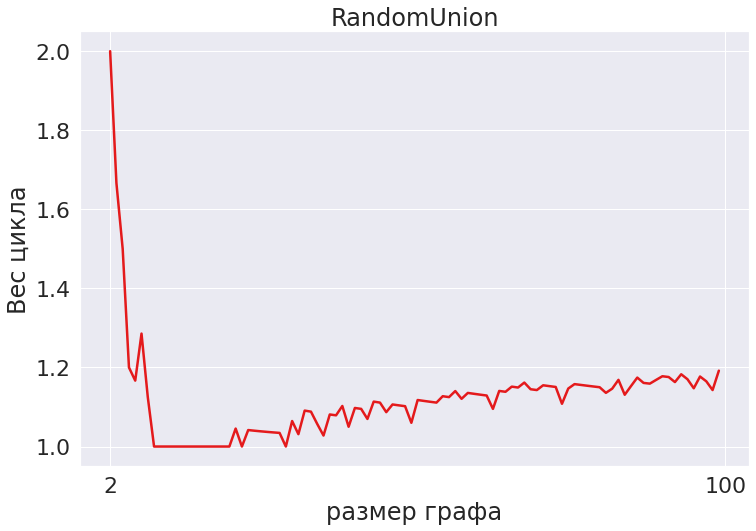

In [18]:
draw_result_graph(results, 'RandomUnion')

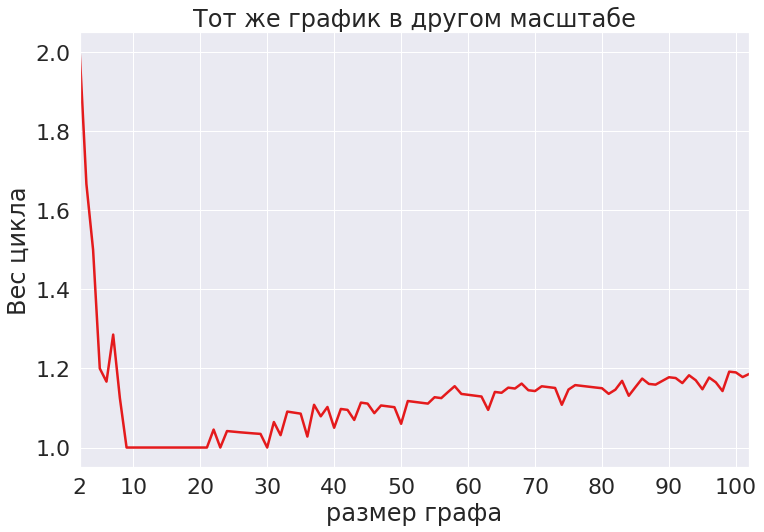

In [11]:
draw_first100_graphs(results, 'Тот же график в другом масштабе')

In [70]:

import pandas as pd

df = pd.DataFrame(np.array(results))
 
df.to_csv('random_union.csv')

In [33]:

#results = np.genfromtxt('original_solver_approximation_k5.csv', delimiter=',')[:, 1]